# Eye Tracking Example

This example demonstrates Akida's eye tracking capabilities using the Brainchip's spatiotemporal architecture.

The notebook below is derived from the ["Efficient online eye tracking with a lightweight spatiotemporal network and event cameras"](https://doc.brainchipinc.com/examples/spatiotemporal/plot_1_eye_tracking_cvpr.html) on the Brainchip Developer MetaTF website.

### Import Necessary Libraries

This cell imports essential libraries: matplotplib for event visualizations, the Akida libraries for model execution..

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
import tensorflow as tf

from cnn2snn import set_akida_version, AkidaVersion
import akida
from akida_models.tenn_spatiotemporal.eye_preprocessing import preprocess_data
from akida_models.tenn_spatiotemporal.eye_losses import process_detector_prediction 

2025-07-31 14:51:11.666786: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 14:51:11.687719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 14:51:11.687736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 14:51:11.688319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 14:51:11.692264: I tensorflow/core/platform/cpu_feature_guar

### Load and segment the sample events

In [2]:
def load_and_segment_npy(file_path, time_window_us=10_000, segment_duration_us=500_000):
    """
    Loads event data from a structured .npy file, splits it into 500ms segments,
    and converts each segment into model-compatible frames using preprocess_data.
    Args:
        file_path (str): Path to the .npy event file (with fields: 'p', 'x', 'y', 't').
        preprocess_data_fn (callable): preprocess_data function to apply per segment.
        time_window_us (int): Time window per frame (default: 10,000µs).
        segment_duration_us (int): Duration of each segment in microseconds (default: 500,000µs).
    Returns:
        list of tf.Tensor: List of processed frame tensors.
    """
    # Load structured event array
    data = np.load(file_path)
    # print(f"Loaded {data.shape[0]} events")

    # Convert structured fields to float32 arrays
    p = data['p'].astype('float32')
    x = data['x'].astype('float32')
    y = data['y'].astype('float32')
    t = data['t'].astype('float32')

    # Prepare stacked event tensor (4, N)
    trial = tf.stack([p, x, y, t], axis=0)

    # Time range
    t_start = t[0]
    t_end = t[-1]

    frames_list = []
    segment_list = []

    current_time = t_start
    while current_time + segment_duration_us <= t_end:
        # Get indices for the current 500ms window
        start_idx = np.searchsorted(t, current_time, side='left')
        end_idx = np.searchsorted(t, current_time + segment_duration_us, side='right')

        # Slice event segment
        segment = tf.stack([
            p[start_idx:end_idx],
            x[start_idx:end_idx],
            y[start_idx:end_idx],
            t[start_idx:end_idx]
        ], axis=0)

        # Dummy label (e.g. center)
        label = tf.convert_to_tensor([[0.5, 0.5, 0]], dtype=tf.float32)

        # Preprocess segment into frames
        frames, _ = preprocess_data(
            events=segment,
            label=label,
            train_mode=False,
            frames_per_segment=1,
            spatial_downsample=(6, 6),
            time_window=time_window_us
        )

        frames_list.append(frames)
        segment_list.append(segment)
        current_time += segment_duration_us

    print(f"Processed {len(frames_list)} segments of 500ms each.")
    return frames_list, segment_list


In [3]:
frames_all, segment_all = load_and_segment_npy("eye_tracking_event_examples.npy")
n_frames = len(frames_all)
N, H, W, n_ch = frames_all[0].shape
print(f"Loaded data with {n_frames} frames, {H}×{W} pixels, {n_ch} channels")

Processed 22 segments of 500ms each.
Loaded data with 22 frames, 80×106 pixels, 2 channels


### Load Pre-trained model

Loads a pre-trained quantized model for eye tracking via `akida_models`.

In [4]:
import akida_models
from akida_models.model_io import load_model
model = load_model("models/tenn_spatiotemporal_eye_buffer_i8_w8_a8.fbz")
print(f"Model input shape: {model.input_shape}")

Model input shape: [80, 106, 2]


Map the `akida_model` onto the device.

In [5]:
with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            model.map(device)
            print(f"Mapping to Akida device {device.desc}.")
            mappedDevice = device.version
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
            mappedDevice = "CPU"
    else:
        print("No Akida devices found, running on CPU.")
        mappedDevice = "CPU"

Available devices: ['fpga-1691']
BC.A2.001.000
Mapping to Akida device fpga-1691.


### Model Summary After Mapping

In [6]:
model.summary()

                                     Model Summary                                      
________________________________________________________________________________________
Input shape   Output shape  Sequences  Layers  NPs  Skip DMAs  External Memory (Bytes)
[80, 106, 2]  [3, 4, 3]     1          20      36   6          307008                 
________________________________________________________________________________________

_________________________
Component (type)  Count
CNP1              23   
_________________________
SKIP_DMA_STORE    6    
_________________________
TNP_B             13   
_________________________
SKIP_DMA_LOAD     6    
_________________________

                      External Memory Summary                       
____________________________________________________________________
Layer (type)                               External Memory (Bytes)
convt_full_0 (BufferTempConv)              101760                 
___________________________________

### Perform eye tracking inference against sample event data

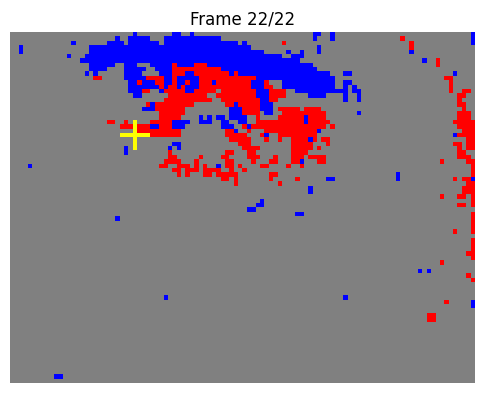

In [7]:
if n_ch == 2:
    # e.g. channel 0 = red, channel 1 = blue
    colors = np.array([[255, 0, 0], [0, 0, 255]], dtype=np.uint8)
else:
    # fallback: pick from matplotlib’s tab10 palette
    import matplotlib
    cmap = matplotlib.cm.get_cmap('tab10', n_ch)
    colors = (cmap(range(n_ch))[:, :3] * 255).astype(np.uint8)

# 3) Create one figure & axis to reuse
fig, ax = plt.subplots(figsize=(6, 6))

frame_number = 0

# Define the size of the cross
cross_size = 3

# 4) Loop over frames, updating in place
for f in frames_all:
    frame_number += 1
    # 4a) start from a mid-gray background
    frame_vis = np.full((H, W, 3), 128, dtype=np.uint8)

    f_np = f.numpy() if isinstance(f, tf.Tensor) else f  # Ensure f is a numpy array
    frame = f_np[0]

    # predict using the model
    pred = model.predict(f_np)

    pred = process_detector_prediction(tf.expand_dims(pred, 0))

    y_pred_x = pred[:, 1] * W
    y_pred_y = pred[:, 0] * H


    # Convert to NumPy scalars
    cx = int(y_pred_x.numpy().flatten()[0])
    cy = int(y_pred_y.numpy().flatten()[0])

    # 4b) paint each channel’s “events” on top
    for ch in range(n_ch):
        
        mask = frame[ :, :, ch] > 0   # assuming >0 marks an event

        pred_mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=bool)
        # Draw a cross centered at (x, y)
        for i in range(-cross_size, cross_size + 1):
            if 0 <= cx + i < frame.shape[0]:
                pred_mask[cx + i, cy] = True
            if 0 <= cy + i < frame.shape[1]:
                pred_mask[cx, cy + i] = True

        frame_vis[mask] = colors[ch]
        frame_vis[pred_mask] = [255, 255, 0]
    
    # 4c) update the image
    ax.clear()
    ax.imshow(frame_vis)
    ax.set_title(f'Frame {frame_number}/{n_frames}')
    ax.axis('off')
    
    # 4d) redraw the same window
    clear_output(wait=True)
    display(fig)
    time.sleep(0.01)   # adjust playback speed

# 5) close when done
plt.close(fig)

### Model Statistics

In [8]:
model.statistics

fps: 15.38, inference clock: 1618856, program clock: 3248046

#### Note: Once you’ve finished running the notebook, ***"Uncomment and run the cell below"*** to release the device and free it up for further experiments.

In [9]:
# import os
# os._exit(00)

#### You can also use this button to reset your kernel

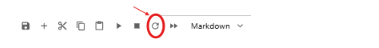